In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense , LSTM , Activation , Dropout , Input , Flatten
from keras.optimizers import Adam

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "/content/drive/My Drive/Data/NSE-TATAGLOBAL11.csv"
df=pd.read_csv(path)

In [44]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [45]:
sys = df.corr()
sys.style.background_gradient()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Open,1,0.998956,0.998776,0.997662,0.997704,0.367503,0.587026
High,0.998956,1,0.998728,0.99913,0.999159,0.388798,0.605907
Low,0.998776,0.998728,1,0.999008,0.999065,0.361695,0.582446
Last,0.997662,0.99913,0.999008,1,0.999963,0.381269,0.599575
Close,0.997704,0.999159,0.999065,0.999963,1,0.380801,0.599155
Total Trade Quantity,0.367503,0.388798,0.361695,0.381269,0.380801,1,0.941976
Turnover (Lacs),0.587026,0.605907,0.582446,0.599575,0.599155,0.941976,1


In [46]:
df['Date'] = pd.to_datetime(df['Date'])
df["Date"].head()

df = df.sort_values(by = 'Date')

df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
1234,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
1233,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
1232,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
1231,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
1230,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


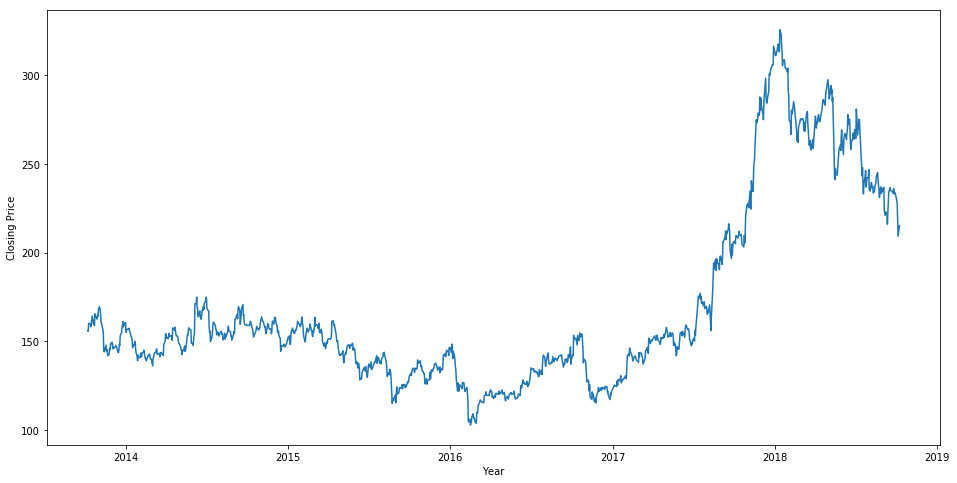

In [47]:
plt.figure(figsize=(16,8))
plt.plot(df["Date"],df["Close"])
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.show()

In [48]:
df.shape

(1235, 8)

In [49]:
#removing unnecessary features

days = df.shape[0]

df["Days"] = pd.Series([i+1 for i in range(days)],index=df.index)

df = df.drop(labels=['Date','High','Low','Last'], axis=1)

df.head()

,Open,Close,Total Trade Quantity,Turnover (Lacs),Days
1234,157.00,155.80,1720413.0,2688.94,1
1233,155.70,155.55,2049580.0,3204.49,2
1232,156.00,160.15,3124853.0,4978.80,3
1231,161.15,160.05,1880046.0,3030.76,4
1230,160.85,159.45,1281419.0,2039.09,5


In [50]:
sys = df.corr()
sys.style.background_gradient()

,Open,Close,Total Trade Quantity,Turnover (Lacs),Days
Open,1,0.997704,0.367503,0.587026,0.612068
Close,0.997704,1,0.380801,0.599155,0.612886
Total Trade Quantity,0.367503,0.380801,1,0.941976,0.209721
Turnover (Lacs),0.587026,0.599155,0.941976,1,0.364159
Days,0.612068,0.612886,0.209721,0.364159,1


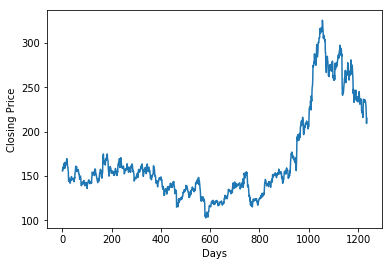

In [51]:
plt.plot(df["Days"],df["Close"])
plt.xlabel("Days")
plt.ylabel("Closing Price")
plt.show()

In [0]:
x = df.loc[:, df.columns!="Close"]
y = df["Close"]

std_x = np.array(np.std(x,axis=0)).reshape(1,4)
mean_x = np.array(np.mean(x,axis=0)).reshape(1,4)

std_y = np.std(y)
mean_y = np.mean(y)

x_train1, x_test1, y_train1,y_test1 = train_test_split(x,y, test_size=0.25,shuffle=False)

In [0]:
def norm(data, mean, std):
  return (data-mean)/std

In [0]:
def inv_norm(data , mean , std):
  return (data*std)+mean

In [55]:
y_train1.shape

(926,)

In [56]:
print(std_x)
print(mean_x)

[[5.14782912e+01 2.27610562e+06 5.34675384e+03 3.56513674e+02]]
[[1.68954858e+02 2.60415114e+06 4.84316650e+03 6.18000000e+02]]


In [0]:
x_train1 = np.array(x_train1)
x_test1 = np.array(x_test1)

y_train1 = np.array(y_train1)
y_test1 = np.array(y_test1)

In [58]:
x_test1.shape

(309, 4)

In [0]:
def built_timeseries(mat, y_, time_stemp):
  dim0 = mat.shape[0]-time_stemp
  dim1 = mat.shape[1]
  x = np.zeros((dim0,time_stemp,dim1))
  y = np.zeros((dim0,1))
  
  for i in range(dim0):
    if (i+time_stemp)<mat.shape[0]:
      x[i,:,:] = mat[i:i+time_stemp]
      y[i] = y_[time_stemp+i]
      
    else:
      x[i,:,:] = mat[i:-1]
      y[i] = y_[-1]
      
  return x,y

In [0]:
time_stemp = 60

x_train,y_train = built_timeseries(norm(x_train1, mean_x,std_x), norm(y_train1, mean_y, std_y), time_stemp)
x_test,y_test = built_timeseries(norm(x_test1, mean_x, std_x) , norm(y_test1, mean_y, std_y), time_stemp)


In [61]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(866, 60, 4)
(866, 1)
(249, 60, 4)
(249, 1)


In [0]:
time_stemps = 60
def model():
  
  input = Input(shape=(time_stemps,4))
  
  output = LSTM(128,return_sequences=True, kernel_initializer='random_uniform')(input)
  output = LSTM(128)(input)
  output = Dense(1)(output)
  
  model = Model(input,output)
  
  model.summary()
  
  model.compile(loss='mse' , optimizer=Adam(lr=0.0001))
  
  return model

In [87]:
model = model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 60, 4)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               68096     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.fit(x_train , y_train , epochs=10 ,batch_size=32, validation_data=(x_test,y_test), shuffle=False)

Train on 866 samples, validate on 249 samples
Epoch 1/10
866/866 [==============================] - 3s 4ms/step - loss: 0.0077 - val_loss: 0.8486
Epoch 2/10
866/866 [==============================] - 3s 4ms/step - loss: 0.0076 - val_loss: 0.8574
Epoch 3/10
866/866 [==============================] - 3s 3ms/step - loss: 0.0076 - val_loss: 0.8351
Epoch 4/10
866/866 [==============================] - 3s 3ms/step - loss: 0.0075 - val_loss: 0.8552
Epoch 5/10
866/866 [==============================] - 3s 3ms/step - loss: 0.0076 - val_loss: 0.8181
Epoch 6/10
866/866 [==============================] - 3s 4ms/step - loss: 0.0074 - val_loss: 0.8593
Epoch 7/10
866/866 [==============================] - 3s 4ms/step - loss: 0.0076 - val_loss: 0.7934
Epoch 8/10
866/866 [==============================] - 3s 4ms/step - loss: 0.0074 - val_loss: 0.8748
Epoch 9/10
866/866 [==============================] - 3s 3ms/step - loss: 0.0080 - val_loss: 0.7543
Epoch 10/10
866/866 [==============================] -

In [95]:
y_pred1 = model.predict(x_train)
y_pred1 = inv_norm(y_pred1, mean_y, std_y)
print(y_pred1)

y_pred = model.predict(x_test)
y_pred = inv_norm(y_pred, mean_y, std_y)
print(y_pred)

[[162.88199 ]
 [162.24841 ]
 [161.84195 ]
 [161.44563 ]
 [161.85857 ]
 [161.80894 ]
 [162.44157 ]
 [162.38512 ]
 [161.80255 ]
 [160.57185 ]
 [160.30923 ]
 [159.3977  ]
 [158.60649 ]
 [157.63199 ]
 [158.60132 ]
 [156.60126 ]
 [155.95544 ]
 [154.6874  ]
 [153.62065 ]
 [152.55853 ]
 [153.31374 ]
 [151.69331 ]
 [150.50528 ]
 [150.21925 ]
 [149.31079 ]
 [150.01817 ]
 [149.69934 ]
 [149.50749 ]
 [149.64038 ]
 [149.98962 ]
 [150.12332 ]
 [149.78812 ]
 [149.40945 ]
 [148.97073 ]
 [148.50629 ]
 [148.03842 ]
 [148.10439 ]
 [148.10722 ]
 [148.49332 ]
 [148.91786 ]
 [148.88991 ]
 [149.20097 ]
 [148.83118 ]
 [148.59198 ]
 [148.94768 ]
 [149.37077 ]
 [149.38976 ]
 [149.61382 ]
 [150.17995 ]
 [150.23625 ]
 [150.01794 ]
 [149.77126 ]
 [150.17293 ]
 [149.78207 ]
 [150.33124 ]
 [149.38513 ]
 [149.54088 ]
 [149.48558 ]
 [149.86128 ]
 [150.60173 ]
 [151.40295 ]
 [152.9494  ]
 [154.98524 ]
 [155.23654 ]
 [155.75867 ]
 [155.9232  ]
 [155.53685 ]
 [156.9027  ]
 [157.1577  ]
 [157.11443 ]
 [157.13075 ]
 [157.

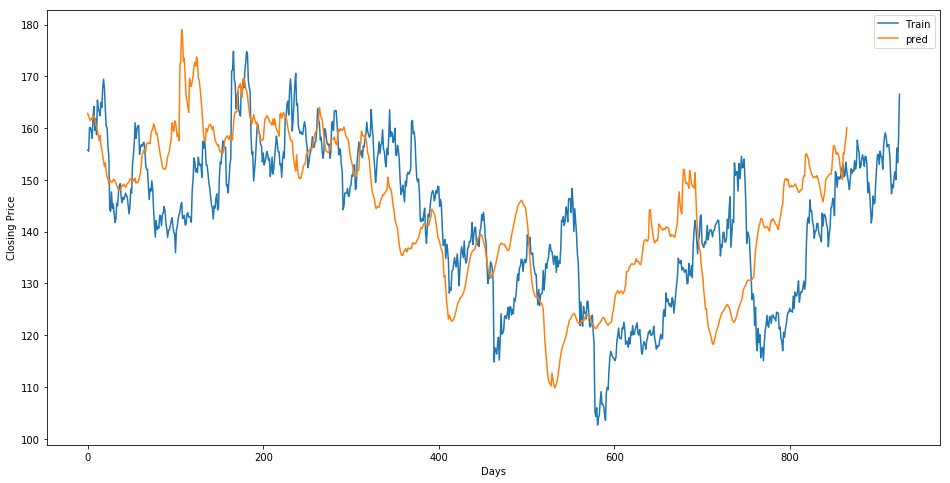

In [96]:
#Train Data
plt.figure(figsize=(16,8))
plt.plot(y_train1,label="Train")
plt.plot(y_pred1, label="pred")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Closing Price")
plt.show()

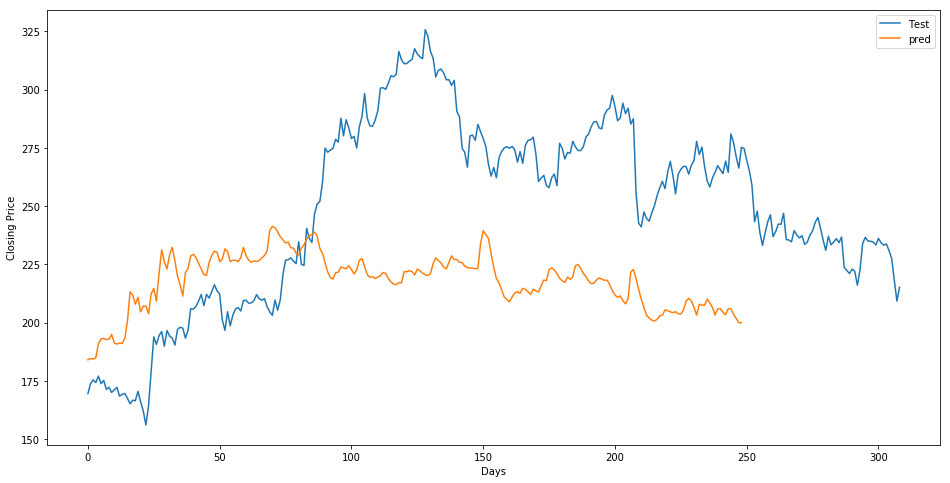

In [97]:
#Test Data
plt.figure(figsize=(16,8))
plt.plot(y_test1,label="Test")
plt.plot(y_pred, label="pred")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Closing Price")
plt.show()